<a href="https://colab.research.google.com/github/briyanyehezkhiel/KPT_C_Program_Deteksi_Influence_Pewarnaan_Graf_Algoritma_Genetika/blob/main/KPT_C_Program_Deteksi_Influence_Pewarnaan_Graf_Algoritma_Genetika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Program Deteksi Influence Pewarnaan Graf Menggunakan Algoritma Genetika - Kelompok 3

#Komputasi Pararel dan Terdistribusi - C

### Nama Anggota:
1. Kholid Fahmi Nasution
2. Nayata Sandra Claudia Nasution
3. Fatihannisa Listy Zulmi
4. Johanes Alberto Siahaan
5. Ronaldo Damianus Parulian Silitonga
6. Lidya Alya Zahra
7. Yusuf Kala
8. Rizky Alpariji
9. Nur Annisa Balqis
10. Aqila Eling Febrianti
11. Muhammad Azi Maulana Manru
12. Frederick Godiva
13. Lukman Nur Hakim
14. Briyan Yehezkhiel
15. Kyla Zahra Winnetou
16. Najwa Afifi Situmorang

# 1. Install dan Import Library yang akan digunakan

In [ ]:
!pip install deap
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np
import seaborn as sns
from deap import base, creator, tools, algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.7 MB/s eta 0:00:00


# 2. Memuat dan Membaca Dataset

In [ ]:
# Load dataset
file_path = '/content/dataset_akhir_fix.csv'
df = pd.read_csv(file_path)

In [ ]:
# Konversi kolom ke string untuk menghindari format eksponensial
df['conversation_id_str'] = df['conversation_id_str'].apply(lambda x: '{:.0f}'.format(float(str(x).replace(',', ''))))

In [ ]:
df['user_id_str'] = df['user_id_str'].apply(lambda x: '{:.0f}'.format(float(str(x).replace(',', ''))))

In [ ]:
df

,conversation_id_str,created_at,favorite_count,quote_count,reply_count,retweet_count,user_id_str,username
0,1260000000000000000,Wed May 20 13:07:59 +0000 2020,5,0,0,1,222870814,indoflyer
1,1260000000000000000,Wed May 20 13:16:26 +0000 2020,0,0,1,0,3248762886,aydarazali
2,1260000000000000000,Wed May 20 14:43:55 +0000 2020,0,0,1,0,1230000000000000000,Irna761
3,1260000000000000000,Wed May 20 14:47:43 +0000 2020,0,0,2,0,1230000000000000000,Irna761
4,1260000000000000000,Wed May 20 15:54:17 +0000 2020,0,0,0,0,113292385,airasia_indo
...,...,...,...,...,...,...,...,...
32907,1780000000000000000,Sun Apr 14 07:06:58 +0000 2024,8521,423,68,2954,2951763288,iwanqais
32908,1540000000000000000,Fri Jun 10 12:48:33 +0000 2022,3857,576,115,3599,2905716522,isusemasaviral
32909,1750000000000000000,Sun Feb 04 01:10:09 +0000 2024,14970,579,335,5853,41284868,rizkidwika
32910,1570000000000000000,Mon Sep 19 10:34:12 +0000 2022,16174,1373,411,17593,183561991,FaraTarmizi


# 3. Ekstrak Fitur

In [ ]:
# Ekstrak relevant columns
df = df[['user_id_str', 'conversation_id_str', 'retweet_count', 'reply_count', 'quote_count', 'favorite_count']]

Pertama, ekstrak kolom-kolom yang relevan dari DataFrame **df** untuk analisis lebih lanjut. Kolom yang dipilih: u**ser_id_str dan conversation_id_str** (untuk mengidentifikasi pengguna dan percakapan), **retweet_count, reply_count, quote_count, dan favorite_count** (untuk menghitung interaksi sosial).

#4. Graphing From Dataset

In [ ]:
# Membuat Sebuah NetworkX graph
G = nx.Graph()

In [ ]:
# Menambahkan nodes and edges
for _, row in df.iterrows():
    user_id = str(row['user_id_str'])
    conversation_id = str(row['conversation_id_str'])
    weight = row['retweet_count'] + row['reply_count'] + row['quote_count'] + row['favorite_count']

    G.add_node(user_id)
    G.add_node(conversation_id)
    G.add_edge(user_id, conversation_id, weight=weight)

Lalu, bangun graf NetworkX di mana setiap pengguna (user_id) dan percakapan (conversation_id) diwakili sebagai **simpul**.
Tepi (edges) antara simpul menunjukkan interaksi antara pengguna dan percakapan, dengan bobot berdasarkan total interaksi (retweet, reply, quote, dan favorite).

#5. Implementasi Pewarnaan Graf Menggunakan Algoritma Genetika

**Inisialisasi Algoritma Genetika dengan DEAP**

In [ ]:
def initialize_genetic_algorithm(G):
    creator.create("FitnessMin", base.Fitness, weights=(1.0,))  # Maksimalkan modularity (positif)
    creator.create("Individual", list, fitness=creator.FitnessMin)

    node_to_index = {node: i for i, node in enumerate(G.nodes())}

    def individual():
        # Membuat individu dengan nilai acak yang lebih baik (membagi node lebih terstruktur)
        return [random.randint(0, len(G.nodes()) - 1) for _ in range(len(G.nodes()))]

    def evaluate_community(individual):
        # Evaluasi modularity untuk komunitas yang ditemukan
        communities = {}
        for i, community_id in enumerate(individual):
            if community_id not in communities:
                communities[community_id] = []
            communities[community_id].append(list(G.nodes())[i])

        # Hitung modularity berdasarkan pembagian komunitas ini
        modularity = nx.algorithms.community.modularity(G, communities.values())

        return modularity,

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(G.nodes()) - 1, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate_community)
    return toolbox

Pada graf G, fungsi initialize_genetic_algorithm(G) mengonfigurasi dan menginisialisasi komponen algoritma genetika untuk deteksi komunitas. Fungsi ini mendefinisikan individu sebagai daftar yang mengandung penugasan komunitas untuk setiap node, di mana komunitas ditentukan secara acak. Untuk menilai, nilai **modularitas** dari pembagian komunitas individu dihitung. Jika komunitas terlalu kecil atau besar, hukuman dapat diterapkan. Operator seperti populasi, pembuatan individu, mutasi, seleksi, crossover (pertukaran informasi antar individu), dan fungsi evaluasi dimasukkan ke dalam toolbox. Semua operator ini diperlukan untuk menjalankan algoritma genetika untuk menemukan komunitas optimal.

**Implementasi Algoritma Genetika untuk Pewarnaan Graf**

In [ ]:
def run_and_visualize_genetic_algorithm(toolbox, G, ngen=50, population_size=10):
    # Membuat populasi awal
    population = toolbox.population(n=population_size)

    # Menjalankan algoritma genetika
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True)

    # Mendapatkan solusi terbaik
    best_individual = tools.selBest(population, k=1)[0]

    # Menetapkan komunitas untuk setiap node
    node_to_index = {node: i for i, node in enumerate(G.nodes())}
    index_to_node = {i: node for i, node in enumerate(G.nodes())}

    # Membuat pemetaan komunitas berdasarkan solusi terbaik
    community_assignment = {index_to_node[i]: best_individual[i] for i in range(len(best_individual))}

    return community_assignment  # Mengembalikan pemetaan komunitas


Fungsi run_and_visualize_genetic_algorithm menjalankan algoritma genetika untuk **deteksi komunitas** dalam graf G. Fungsi ini pertama-tama membuat populasi awal, lalu menjalankan algoritma genetika menggunakan operator crossover (cxpb) dan mutasi (mutpb). Setelah sejumlah generasi, solusi terbaik (individu dengan nilai fitness tertinggi) dipilih, dan komunitas untuk setiap node dalam graf ditetapkan berdasarkan individu terbaik tersebut. Fungsi ini mengembalikan pemetaan komunitas yang menghubungkan setiap node dengan ID komunitas yang ditugaskan.

**Deteksi Komunitas**

In [ ]:
# Inisialisasi toolbox terlebih dahulu
toolbox = initialize_genetic_algorithm(G)

In [ ]:
# Menjalankan algoritma genetika untuk mendapatkan komunitas dengan pengaturan lebih cepat
community_assignment = run_and_visualize_genetic_algorithm(toolbox, G)

gen	nevals
0  	10    
1  	6     
2  	7     
3  	5     
4  	4     
5  	7     
6  	4     
7  	2     
8  	10    
9  	8     
10 	6     
11 	7     
12 	5     
13 	4     
14 	6     
15 	3     
16 	6     
17 	3     
18 	8     
19 	7     
20 	5     
21 	4     
22 	6     
23 	4     
24 	10    
25 	8     
26 	5     
27 	4     


In [ ]:
# Tetapkan label komunitas ke node (Algoritma Genetika)
for node, community in community_assignment.items():
    G.nodes[node]['community'] = community

Fungsi ini menetapkan label komunitas yang diperoleh dari algoritma genetika ke node-node dalam graf G. Hal ini memungkinkan setiap node untuk memiliki informasi tentang komunitas tempat node berada berdasarkan hasil deteksi komunitas dari algoritma genetika.

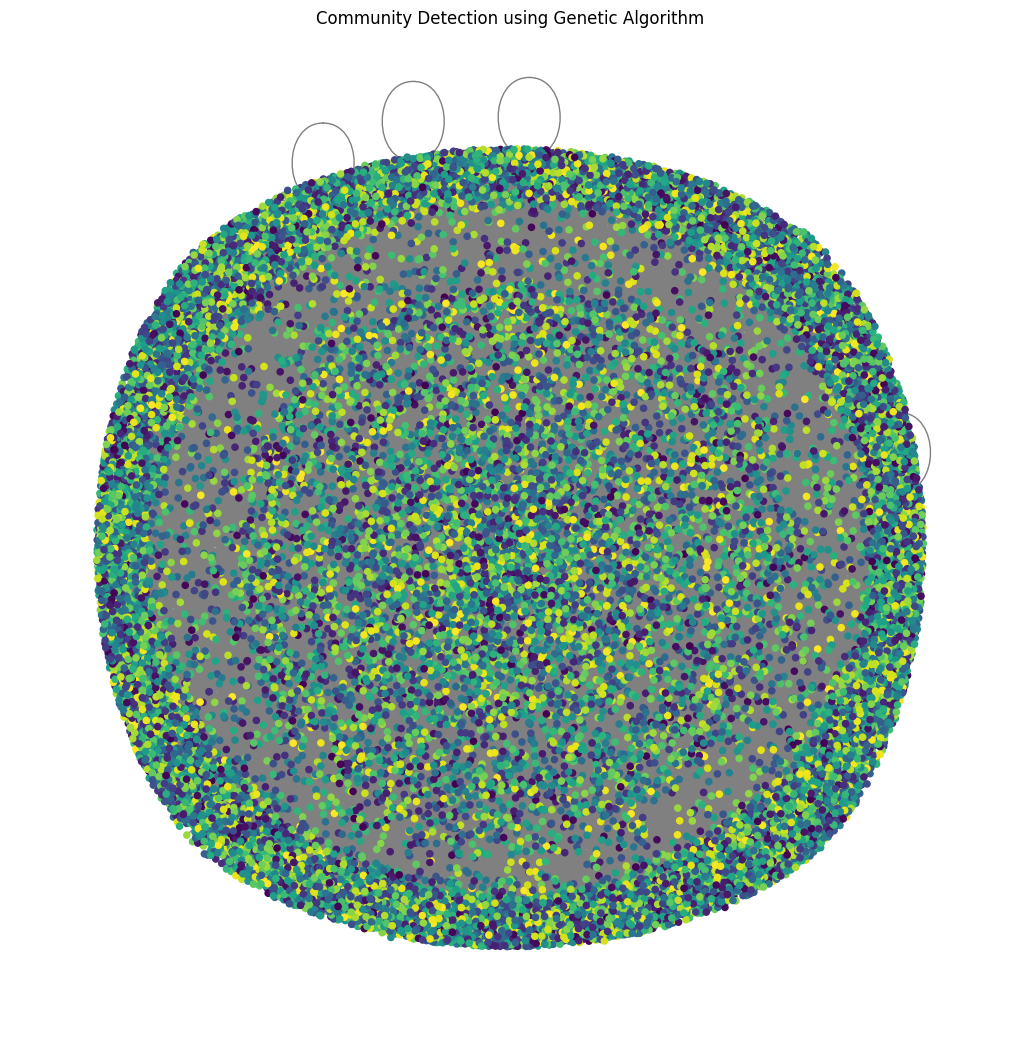

In [ ]:
# Visualisasi pewarnaan komunitas
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.1, iterations=50)  # Menghitung posisi node untuk visualisasi
community_colors = [community_assignment[node] for node in G.nodes()]  # Mendapatkan warna berdasarkan pemetaan komunitas
nx.draw(G, pos, node_color=community_colors, node_size=20, edge_color='gray', with_labels=False)  # Menggambar graf
plt.title("Community Detection using Genetic Algorithm")
plt.show()

Hasil visualisasi grafik menggunakan community colors

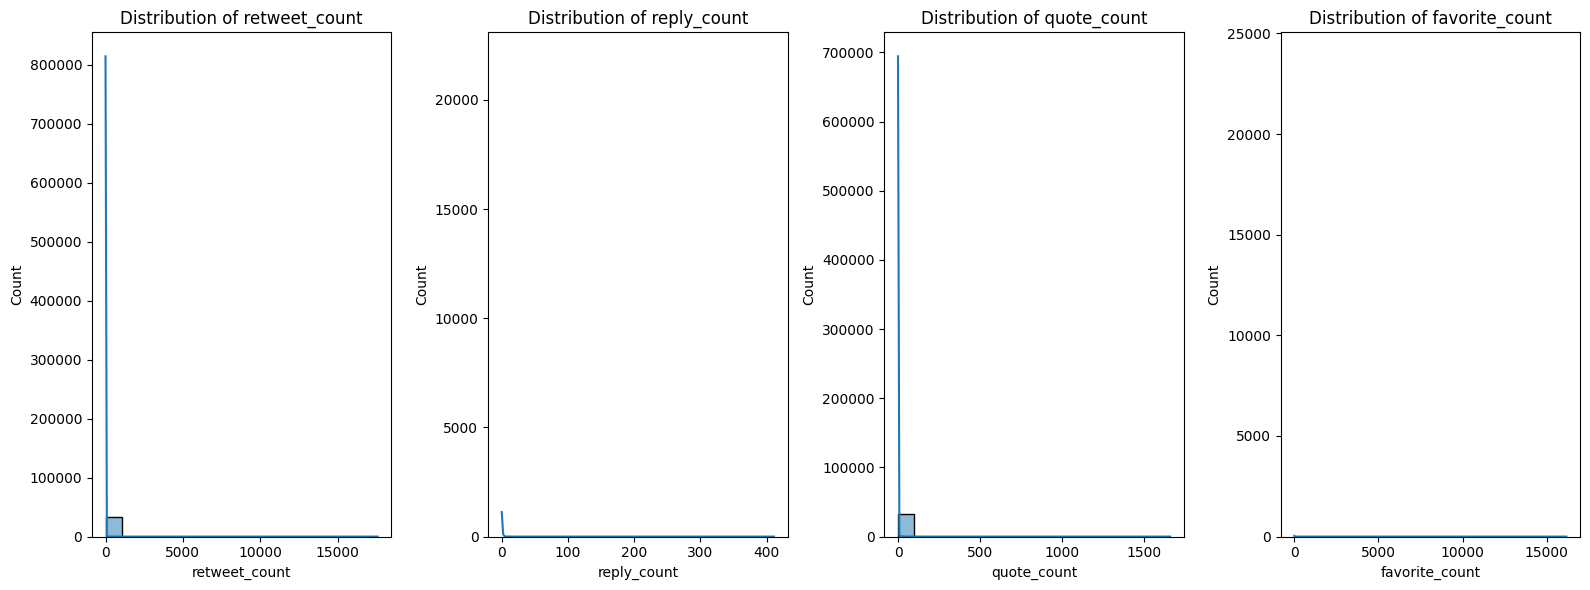

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan data tidak mengandung NaN
df = df.dropna(subset=['retweet_count', 'reply_count', 'quote_count', 'favorite_count'])

# Plot the distribution of features
plt.figure(figsize=(16, 6))
for i, col in enumerate(['retweet_count', 'reply_count', 'quote_count', 'favorite_count'], 1):
    plt.subplot(1, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Hasil plot histogram dan distribusi untuk setiap fitur interaksi sosial

#6. Mencari Nilai Modularitas, Nilai Silhouette Coefficient, dan Nilai adjusted_rand_index

In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
import networkx as nx
import numpy as np

# Function untuk menghitung modularity
def calculate_modularity(G, community_assignment):
    # Membuat pemetaan komunitas berdasarkan solusi yang dihasilkan algoritma genetika
    communities = {}
    for node, community in community_assignment.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    # Komputasi modularity
    modularity = nx.algorithms.community.modularity(G, communities.values())
    return modularity

# Function untuk menghitung silhouette coefficient
def calculate_silhouette_coefficient(G, community_assignment):
    # Membuat array komunitas untuk setiap node
    community_labels = [community_assignment[node] for node in G.nodes()]

    # Menghitung silhouette score
    # Menggunakan bobot edge sebagai jarak antar node
    adj_matrix = nx.to_numpy_array(G)  # Menggunakan to_numpy_array() sebagai pengganti to_numpy_matrix()

    # Mengisi diagonal dengan nol agar tidak ada jarak antara node dengan dirinya sendiri
    np.fill_diagonal(adj_matrix, 0)

    silhouette_avg = silhouette_score(adj_matrix, community_labels, metric="precomputed")
    return silhouette_avg

# Function untuk menghitung adjusted rand index (ARI)
def calculate_ari(G, community_assignment):
    # Membuat array komunitas untuk setiap node
    community_labels = [community_assignment[node] for node in G.nodes()]

    ari = adjusted_rand_score(community_labels, community_labels)
    return ari

# Hitung metrik evaluasi
modularity = calculate_modularity(G, community_assignment)
silhouette_avg = calculate_silhouette_coefficient(G, community_assignment)
ari = calculate_ari(G, community_assignment)

# Print hasil metrik evaluasi
print(f"Modularity: {modularity}")
print(f"Silhouette Coefficient: {silhouette_avg}")
print(f"Adjusted Rand Index: {ari}")

Modularity: -0.023424089089058898
Silhouette Coefficient: -0.000890125173852573
Adjusted Rand Index: 1.0


Modularity mengevaluasi kekuatan struktur komunitas dalam jaringan. Modularity mengukur kualitas pembagian komunitas dalam graf. Semakin tinggi modularity, semakin baik pembagian komunitas yang ada. Rentang nilai modularity adalah -1 hingga 1. Dari percobaan model pertama yang didapat, nilai modularitynya **masih sangat buruk** sehingga akan dioptimalisasi lagi pada tahap selanjutnya.


Silhouette Coefficient memberikan gambaran tentang seberapa baik setiap data dikelompokkan dalam komunitas tertentu berdasarkan fitur-fitur yang terlibat. Nilainya berkisar antara -1 hingga 1, sehingga nilai yang lebih dekat ke 1 menunjukkan klaster yang terdefinisi dengan baik. Dari percobaan model pertama yang didapat, nilai silhouettenya **masih sangat buruk** sehingga akan dioptimalisasi lagi pada tahap selanjutnya.


Adjusted Rand Index (ARI) mengukur kesamaan antara dua pembagian (misalnya, pembagian komunitas yang ditemukan oleh algoritma dengan pembagian yang sebenarnya) dengan memperhitungkan kemungkinan kesamaan secara acak. Rentang nilai ARI adalah -1 hingga 1. Dari percobaan pertama, nilai ARI **Sudah Sangat Baik**. Sehingga tidak memerlukan langkah pengoptimalisasian lanjut.


#7. Optimalisasi Deteksi Komunitas Menggunakan Pendekatan Fixed Weighting


Optimalisasi ini menggunakan bobot tetap dalam menghitung edge weight untuk membangun graf interaksi antar pengguna dan percakapan. Bobotnya dihitung sebagai kombinasi linier dari beberapa metrik keterlibatan: retweet count, reply count, quote count, dan favorite count dengan **proporsi bobot** masing-masing: **0.4, 0.3, 0.2, dan 0.1**.

In [ ]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import networkx as nx
import numpy as np
from sklearn.metrics import silhouette_score

df_sampled = resample(df, n_samples=10000, random_state=42)

# Terapkan transformasi log dan normalisasi fitur
df_sampled['retweet_count'] = np.log1p(df_sampled['retweet_count'])
df_sampled['reply_count'] = np.log1p(df_sampled['reply_count'])
df_sampled['quote_count'] = np.log1p(df_sampled['quote_count'])
df_sampled['favorite_count'] = np.log1p(df_sampled['favorite_count'])

scaler = StandardScaler()
df_sampled[['retweet_count', 'reply_count', 'quote_count', 'favorite_count']] = scaler.fit_transform(
    df_sampled[['retweet_count', 'reply_count', 'quote_count', 'favorite_count']]
)

# Pastikan user_id_str dan conversation_id_str memiliki tipe yang konsisten
df_sampled['user_id_str'] = df_sampled['user_id_str'].astype(str)
df_sampled['conversation_id_str'] = df_sampled['conversation_id_str'].astype(str)

# Buat ulang grafik untuk memastikan semua node memiliki tipe yang benar
G = nx.Graph()
for _, row in df_sampled.iterrows():
    user_id = row['user_id_str']
    conversation_id = row['conversation_id_str']
    weight = (0.4 * row['retweet_count'] +
              0.3 * row['reply_count'] +
              0.2 * row['quote_count'] +
              0.1 * row['favorite_count'])

    if 0.1 < weight < 5:
        G.add_node(user_id)
        G.add_node(conversation_id)
        G.add_edge(user_id, conversation_id, weight=weight)

# Inisialisasi dan jalankan algoritma genetik untuk mendapatkan penugasan komunitas
toolbox = initialize_genetic_algorithm(G)
community_assignment = run_and_visualize_genetic_algorithm(toolbox, G)

# Tetapkan label komunitas ke node (Algoritma Genetika)
for node, community in community_assignment.items():
    G.nodes[node]['community'] = community

# Perbarui node_community_mapping dengan tipe yang konsisten
node_community_mapping = {str(node): G.nodes[node]['community'] for node in G.nodes}

# Buat label untuk evaluasi skor siluet, pastikan node ditemukan di node_community_mapping
X = df_sampled[['retweet_count', 'reply_count', 'quote_count', 'favorite_count']]
labels = [node_community_mapping.get(str(node), -1) for node in df_sampled['user_id_str']]

# Filter titik data tempat label komunitas ditemukan
valid_indices = [i for i, label in enumerate(labels) if label != -1]
X = X.iloc[valid_indices]
labels = [labels[i] for i in valid_indices]

# Hitung silhouette score and modularity
if len(set(labels)) > 1:  # Skor siluet hanya berlaku jika lebih dari satu label unik
    silhouette_avg = silhouette_score(X, labels)
    print(f'Silhouette Coefficient (final optimized): {silhouette_avg:.4f}')
else:
    print("Silhouette Coefficient cannot be computed because there is only one community label.")

# Menghitung modularity menggunakan the community assignment
modularity = calculate_modularity(G, community_assignment)
print(f'Modularity (final optimized): {modularity:.4f}')


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Silhouette Coefficient (final optimized): -0.8462
Modularity (final optimized): 0.0239


Nilai pada percobaan kedua untuk Silhouette Coefficient dan Modularity nya masih **Buruk** sehingga akan di optimalisasi pada tahap selanjutnya.

## Optimalisasi Deteksi Komunitas Menggunakan Algoritma Genetika

In [ ]:
from deap import base, creator, tools, algorithms
import random

# Konfigurasi algoritma genetika
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maksimalkan modularitas
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_community", lambda: random.randint(0, 5))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_community, n=len(G.nodes))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fungsi evaluasi: menghitung modularitas
def evaluate(individual):
    community_map = {str(node): individual[i] for i, node in enumerate(G.nodes)}
    for node, community in community_map.items():
        G.nodes[node]['community'] = community

    partition_temp = [[node for node, data in G.nodes(data=True) if data['community'] == c]
                      for c in set(individual)]
    modularity_temp = nx.algorithms.community.quality.modularity(G, partition_temp)
    return modularity_temp,

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxUniform, indpb=0.5)  # Cross-over
toolbox.register("mutate", tools.mutUniformInt, low=0, up=5, indpb=0.2)  # Mutasi
toolbox.register("select", tools.selTournament, tournsize=3)

# Proses algoritma genetika
population = toolbox.population(n=100)  # Ukuran populasi
n_generations = 50  # Jumlah generasi
hall_of_fame = tools.HallOfFame(1)  # Menyimpan individu terbaik
stats = tools.Statistics(lambda ind: ind.fitness.values[0])  # Ambil nilai fitness pertama (modularitas)
stats.register("avg", lambda x: sum(x) / len(x))
stats.register("min", min)
stats.register("max", max)

# Menjalankan algoritma
algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=n_generations,
                    stats=stats, halloffame=hall_of_fame, verbose=True)

# Evaluasi hasil terbaik
best_individual = hall_of_fame[0]
community_mapping = {str(node): best_individual[i] for i, node in enumerate(G.nodes)}

# Menghitung Silhouette Score
labels = [community_mapping.get(str(node), -1) for node in df_sampled['user_id_str']]

# Filter valid data points
valid_indices = [i for i, label in enumerate(labels) if label != -1]
X = df_sampled.iloc[valid_indices][['retweet_count', 'reply_count', 'quote_count', 'favorite_count']]
labels = [labels[i] for i in valid_indices]

if len(set(labels)) > 1:  # Valid jika lebih dari satu label unik
    silhouette_avg = silhouette_score(X, labels)
    print(f'Silhouette Coefficient (genetic algorithm): {silhouette_avg:.4f}')
else:
    print("Silhouette Coefficient tidak dapat dihitung karena hanya satu label komunitas.")

# Hitung modularitas akhir
partition = [[node for node, label in community_mapping.items() if label == c]
             for c in set(community_mapping.values())]
final_modularity = nx.algorithms.community.quality.modularity(G, partition)
print(f'Modularity (genetic algorithm): {final_modularity:.4f}')


gen	nevals	avg       	min      	max      
0  	100   	-0.0280306	-0.135405	0.0918571
1  	68    	0.0116568 	-0.0976406	0.140661 
2  	78    	0.0298751 	-0.0921601	0.149893 
3  	71    	0.0464047 	-0.108186 	0.215134 
4  	73    	0.0599308 	-0.107485 	0.191381 
5  	80    	0.073105  	-0.112146 	0.199162 
6  	79    	0.0822091 	-0.0993758	0.250105 
7  	69    	0.0952847 	-0.0954107	0.250105 
8  	79    	0.109547  	-0.123942 	0.253626 
9  	82    	0.11513   	-0.0493754	0.241231 
10 	79    	0.145394  	-0.0641445	0.241231 
11 	74    	0.169682  	-0.0431904	0.252676 
12 	76    	0.18374   	-0.101329 	0.28787  
13 	72    	0.209722  	-0.0183108	0.32099  
14 	72    	0.219303  	-0.015724 	0.321411 
15 	79    	0.231063  	-0.0398933	0.336596 
16 	76    	0.249505  	-0.00795205	0.336596 
17 	73    	0.263625  	0.00747396 	0.336596 
18 	78    	0.271127  	0.0442713  	0.353271 
19 	76    	0.276093  	0.0526162  	0.346335 
20 	84    	0.282709  	-0.0302432 	0.378878 
21 	73    	0.29873   	0.0101207  	0.398198 
22 	72 

Pada percobaan ketiga untuk nilai Silhouette Coefficientnya sudah lebih baik dari sebelumnya.

Untuk nilai Modularity nya sudah **Cukup Baik**. Angka 0.4596 menunjukkan bahwa pembagian komunitas sudah terstruktur degan baik.

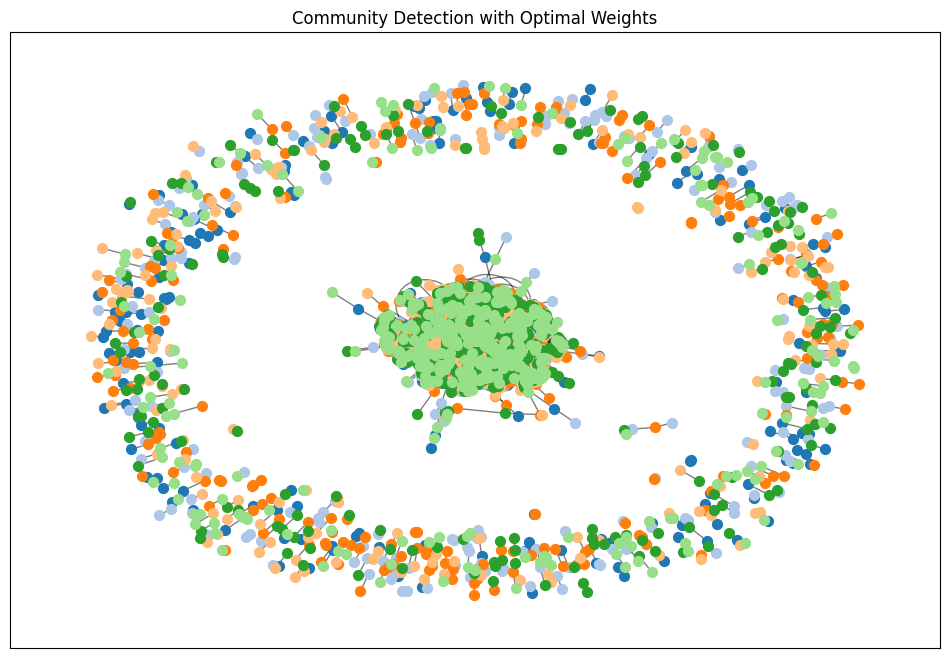

In [ ]:
# Visualize the graph with community colors
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Layout posisi node
communities = set(nx.get_node_attributes(G, 'community').values())  # Ambil komunitas
colors = plt.cm.tab20.colors  # Pilih palet warna untuk komunitas

for community in communities:
    node_list = [node for node in G.nodes if G.nodes[node]['community'] == community]
    nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_size=50, node_color=[colors[community % len(colors)]])  # Node dengan warna komunitas
nx.draw_networkx_edges(G, pos, alpha=0.5)  # Gambar edges dengan transparansi
plt.title('Community Detection with Optimal Weights')
plt.show()

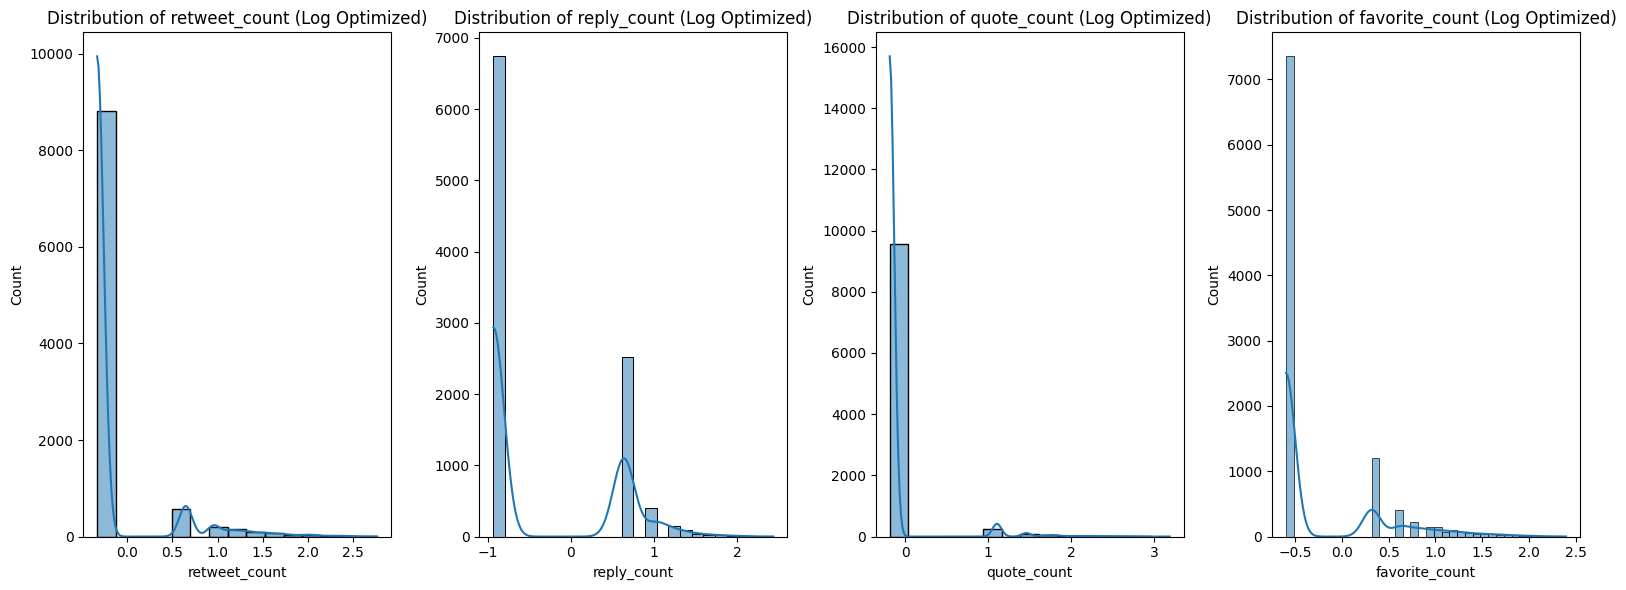

In [ ]:
# Transformasi logaritmik pada fitur dan visualisasi distribusinya
df_sampled_log = df_sampled[['retweet_count', 'reply_count', 'quote_count', 'favorite_count']].apply(lambda x: np.log1p(x))  # Transformasi log

# Plot distribusi fitur setelah normalisasi dan log transformasi
plt.figure(figsize=(16, 6))
for i, col in enumerate(df_sampled_log.columns, 1):
    plt.subplot(1, 4, i)
    sns.histplot(df_sampled_log[col], kde=True)
    plt.title(f'Distribution of {col} (Log Optimized)')
plt.tight_layout()
plt.show()